In [1]:

import torch
import torchvision
from torch import nn 
#from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import random
import dataset_utils
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)

In [3]:

batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_val, X_test, y_train_val, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_val
train_data['species_name'] = y_train_val

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
'''from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=2000,shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=False, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)'''

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object


'from torch.utils.data import Dataset, DataLoader\n \nclass WholeDataset(Dataset):\n    def __init__(self, data, transform=None):\n        self.data = data\n        self.targets = data.targets#torch.tensor(targets)\n        #self.transform = transform\n        \n    def __getitem__(self, index):\n        x = self.data[index][0]\n        y = self.targets[index]\n        \n        return x, y\n    \n    def __len__(self):\n        return len(self.data)\n        \nwhole_dataset = WholeDataset(image_dataset)\nn_classes = np.unique(whole_dataset.targets).shape[0]\nprint(len(test_indices+val_indices+train_indices))\nlen(whole_dataset)\n\ntrain_imgs = torch.utils.data.Subset(whole_dataset, train_indices)\nval_imgs = torch.utils.data.Subset(whole_dataset, val_indices)\ntest_imgs = torch.utils.data.Subset(whole_dataset, test_indices)\nlen(train_imgs)+len(val_imgs)+len(test_imgs)\ntrain_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=False, num_workers=2)\nval_load

In [4]:
train_labels = np.array(image_dataset.imgs)[train_indices][:,1].astype(int)
val_labels = np.array(image_dataset.imgs)[val_indices][:,1].astype(int)

In [5]:

y_train = y_train.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])
y_test = y_test.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])
y_validation= y_validation.apply(lambda x: image_dataset.class_to_idx[x.replace(' ','_')])

In [6]:
class DNAdataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = torch.tensor(np.float32(self.data[index][0])).unsqueeze(0)
        y = self.targets[index]
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
d_train = DNAdataset(X_train.values, y_train.values)
d_val = DNAdataset(X_validation.values, y_validation.values)

In [7]:
dataloader_train = DataLoader(d_train, batch_size=32,shuffle=True)
dataloader_val = DataLoader(d_val, batch_size=32,shuffle=True)
dataloaders = {'train':dataloader_train,'val':dataloader_val}
dataset_sizes = {'train': d_train.data.shape[0], 'val':d_val.data.shape[0]}

In [8]:

from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        for dnas,labels in tqdm(dataloaders['train']):
            model.train()
            dnas = dnas.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            predicted_labels = model(dnas)
            train_loss = criterion(predicted_labels,labels)
            train_loss.backward()
            optimizer.step()
            
            _, preds = torch.max(predicted_labels, 1)
            #print(preds)
            #print(labels.data)
            running_train_corrects += torch.sum(preds == labels.data)
        train_losses.append(train_loss)
        
        running_val_corrects = 0
        for dnas,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                dnas = dnas.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                predicted_labels = model(dnas)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                #print(preds)
                #print(labels.data)
                running_val_corrects += torch.sum(preds == labels.data)
        val_losses.append(val_loss)
        
        
        
        #real_scores.append(real_score)
        #fit_p.writer.add_scalar('loss_g', loss_g, epoch)
        # Log losses & scores (last batch)
        
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc))
        #print(f"class accuracy real {class_accuracy_real}")
    
    return train_losses

In [22]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        #self.linear1 = torch.nn.Linear(658, 200)
        self.conv1 = torch.nn.Conv2d(1,8,(5,1))
        self.activation1 = torch.nn.LeakyReLU()
        self.norm1 = torch.nn.BatchNorm2d(8)
        self.conv2 = torch.nn.Conv2d(8,1,(5,1))
        self.activation2 = torch.nn.LeakyReLU()
        self.norm2 = torch.nn.BatchNorm2d(1)
        #self.conv2 = torch.nn.Conv2d(2, 2,1)
        #self.conv2 = torch.nn.Conv2d(5,1,(3,1))
        #self.activation2 = torch.nn.LeakyReLU()
        #self.norm2 = torch.nn.BatchNorm2d(1)
        self.flat = torch.nn.Flatten()
        self.linear = torch.nn.Linear(3250,1500)
        self.dropout= torch.nn.Dropout(0.70)
        self.activation3 = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(1500,1050)
        #self.softmax = torch.nn.Softmax()
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.norm2(x)
        #x = self.conv2(x)
        #x = self.activation2(x)
        #x = self.norm2(x)
        x = self.flat(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.activation3(x)
        x = self.linear2(x)
        #x = self.softmax(x)
        return x
    def feature_extract(self,x):
        print(x.shape)

        x = self.conv1(x)
        x = self.activation1(x)
        x = self.norm1(x)
        #x = self.conv2(x)
        #x = self.activation2(x)
        #x = self.norm2(x)

        x = self.flat(x)
        #x = self.linear(x)
        return x

tinymodel = TinyModel()
tinymodel.cuda()
 
optimizer = torch.optim.Adam(tinymodel.parameters(),weight_decay=1e-5)


In [23]:
fit(24,dataloaders,optimizer,tinymodel)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/24], train_loss: 7.0716,  train_score: 0.0005,val_loss: 6.9474,  val_score: 0.0262


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/24], train_loss: 6.3469,  train_score: 0.0554,val_loss: 6.9386,  val_score: 0.0377


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/24], train_loss: 5.8147,  train_score: 0.0806,val_loss: 6.9340,  val_score: 0.0516


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/24], train_loss: 5.3570,  train_score: 0.1342,val_loss: 6.9301,  val_score: 0.0583


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/24], train_loss: 4.9128,  train_score: 0.2030,val_loss: 6.9300,  val_score: 0.0748


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/24], train_loss: 4.5009,  train_score: 0.2430,val_loss: 6.9338,  val_score: 0.0774


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/24], train_loss: 4.1058,  train_score: 0.3157,val_loss: 6.9380,  val_score: 0.0889


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/24], train_loss: 3.7299,  train_score: 0.3921,val_loss: 6.9428,  val_score: 0.1020


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/24], train_loss: 3.3583,  train_score: 0.4695,val_loss: 6.9508,  val_score: 0.1061


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/24], train_loss: 3.0117,  train_score: 0.5350,val_loss: 6.9650,  val_score: 0.1329


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/24], train_loss: 2.6537,  train_score: 0.6084,val_loss: 6.9848,  val_score: 0.1578


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/24], train_loss: 2.3326,  train_score: 0.6720,val_loss: 7.0081,  val_score: 0.1805


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/24], train_loss: 2.0189,  train_score: 0.7276,val_loss: 7.0347,  val_score: 0.2002


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/24], train_loss: 1.7278,  train_score: 0.7745,val_loss: 7.0625,  val_score: 0.2244


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/24], train_loss: 1.4611,  train_score: 0.8168,val_loss: 7.0855,  val_score: 0.2533


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/24], train_loss: 1.2154,  train_score: 0.8538,val_loss: 7.0995,  val_score: 0.2721


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/24], train_loss: 1.0118,  train_score: 0.8828,val_loss: 7.1071,  val_score: 0.3061


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/24], train_loss: 0.8376,  train_score: 0.9038,val_loss: 7.1093,  val_score: 0.3378


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/24], train_loss: 0.6826,  train_score: 0.9223,val_loss: 7.1063,  val_score: 0.3651


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/24], train_loss: 0.5506,  train_score: 0.9343,val_loss: 7.0989,  val_score: 0.3929


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/24], train_loss: 0.4543,  train_score: 0.9451,val_loss: 7.0882,  val_score: 0.4151


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/24], train_loss: 0.3689,  train_score: 0.9552,val_loss: 7.0731,  val_score: 0.4335


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/24], train_loss: 0.3041,  train_score: 0.9634,val_loss: 7.0549,  val_score: 0.4450


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/24], train_loss: 0.2512,  train_score: 0.9679,val_loss: 7.0342,  val_score: 0.4496


[tensor(7.0716, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(6.3469, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(5.8147, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(5.3570, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.9128, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.5009, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(4.1058, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.7299, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.3583, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(3.0117, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.6537, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3326, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0189, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.7278, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.4611, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.2154, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [24]:

dataloader_train = DataLoader(d_train, batch_size=len(d_train))
dataloader_val = DataLoader(d_val, batch_size=len(d_val))
dataloaders = {'train':dataloader_train,'val':dataloader_val}
dataset_sizes = {'train': d_train.data.shape[0], 'val':d_val.data.shape[0]}

In [25]:
tinymodel.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():

    for dnas,labels in dataloaders['train']:
        dnas = dnas.to(device)
        train_dna_features = tinymodel.feature_extract(dnas)
        train_dna_labels = labels
    for dnas,labels in dataloaders['val']:
        dnas = dnas.to(device)
        val_dna_features = tinymodel.feature_extract(dnas)
        val_dna_labels = labels
print(train_dna_features.shape)

train_dna_features = train_dna_features.cpu()
val_dna_features = val_dna_features.cpu()

torch.Size([10840, 1, 658, 5])
torch.Size([5645, 1, 658, 5])
torch.Size([10840, 26160])


In [26]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 

clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(train_dna_features,train_dna_labels )

In [27]:
train_predicted_labels = clf.predict(train_dna_features)
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==train_dna_labels.numpy())/len(train_dna_labels)}")

Training species accuracy:0.9994464944649446


In [28]:
val_predicted_labels= clf.predict(val_dna_features)
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==val_dna_labels.numpy())/len(val_dna_labels)}")

Validation species accuracy:0.47068201948627103


In [29]:

temp_val_predicted_probs = clf.predict_proba(val_dna_features)
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),1050))
for i, cls in enumerate(np.arange(1050)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]
import math
n_correct_genus = 0
for i in range(len(val_dna_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[val_dna_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(val_dna_labels)}")


Validation genus accuracy: 0.7906111603188662


In [30]:
def entropy_per_symbol(v):
    if len(v)==1:
        return 0.0
    entropy = 0 
    n_zeros = 0
    for p in v:
        if p != 0:
            entropy-=p*math.log(p,2)
        else:
            n_zeros +=1
    #print(f"n_zeros:{n_zeros}")
    #FORSE VA TOLTO N_ZEROS DALLA LENGTH
    mean_symbol_entropy = entropy/math.log(len(normalized_reduced_species),2)
    return mean_symbol_entropy

In [80]:

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,10,1):
    entropy_threshold = t/10.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(val_dna_labels)):
        #label_best_specie = val_predicted_probs[i].argmax()
        label_best_specie = val_predicted_labels[i]
        assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
        #print(val_labels[i])
        #print(label_best_specie)
        #print(species_same_genus)
        reduced_species = val_predicted_probs[i][species_same_genus]
        normalized_reduced_species = reduced_species/(reduced_species.sum())
        #print(normalized_reduced_species)
        H_s = entropy_per_symbol(normalized_reduced_species)
        #print(H_s)
        #print("Genus" if H_s > entropy_threshold else "Species")
        #input() 
        if val_dna_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if H_s < entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == val_dna_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if H_s >= entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[val_dna_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
            
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples)#TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples)#1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

(0.0, 1.0)

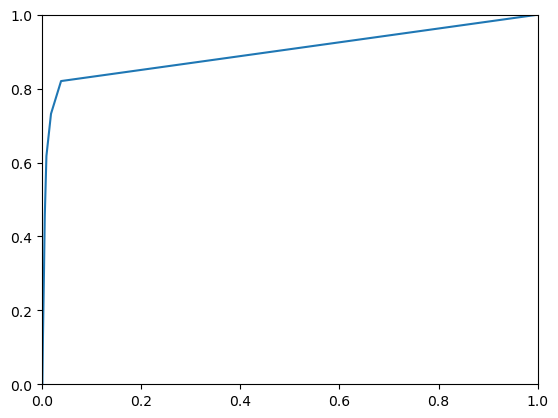

In [81]:

plt.plot(fprs,tprs)
plt.xlim([0, 1])
plt.ylim([0, 1])

In [82]:
fprs[1]

0.03873109553670229

In [83]:
tprs[1]

0.8203817314246762

In [84]:
train_dna_labels.shape

torch.Size([10840])

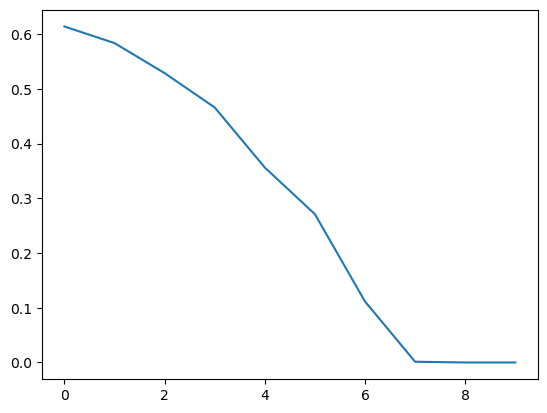

In [85]:
plt.plot(correct_genus_rate)

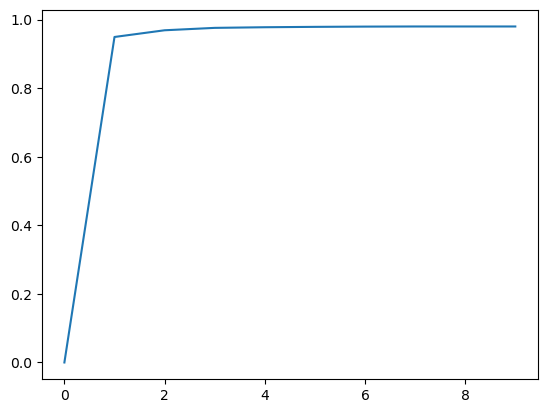

In [86]:
plt.plot(correct_species_rate)

In [87]:
correct_species_rate[1]

0.949465142014017

In [88]:
correct_genus_rate[1]

0.5835037491479209

In [90]:
train_dna_features.shape

torch.Size([10840, 26160])

In [101]:
for i,row in enumerate(df['image_urls']):
    print(i,sep=" ")
    print(row)
    input()

0
http://v3.boldsystems.org/pics/ANICL/10ANIC_08059+1288052608.jpg


1
http://v3.boldsystems.org/pics/BCHYM/BC_ZSM_HYM_24216+1440710108.jpg


2
http://v3.boldsystems.org/pics/BCHYM/BC-ZSM-HYM-27761-D07+1429045164.jpg


3
http://v3.boldsystems.org/pics/BLPBC/06-SRNP-109430_DHJ609430+1199992320.jpg


4
http://v3.boldsystems.org/pics/BLPBE/07-SRNP-101378_DHJ611342+1174583648.jpg


5
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-106954_DHJ616918+1188495614.jpg


6
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-112250_DHJ622214+1202911152.jpg


7
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-113574_DHJ623538+1204038314.jpg


8
http://v3.boldsystems.org/pics/BLPDE/08-SRNP-108981-DHJ633045+1364926698.jpg


9
http://v3.boldsystems.org/pics/BLPEE/12-SRNP-100569-DHJ667502+1344956152.JPG


10
http://v3.boldsystems.org/pics/CGUKC/IMG_9917+1238606356.JPG


11
http://v3.boldsystems.org/pics/COLFC/ZMUO.003008+1335376308.JPG


12
http://v3.boldsystems.org/pics/COLFD/ZMUO.003858+1350573868.JPG


13
http://v3.boldsystems.org/pics/COLFD/ZMUO.004405+1350330438.JPG


14
http://v3.boldsystems.org/pics/COLFD/ZMUO.004819+1358948634.JPG


15
http://v3.boldsystems.org/pics/COLFD/ZMUO.004472+1361902940.JPG


16
http://v3.boldsystems.org/pics/COLFE/ZMUO.007266+1367984782.JPG


17
http://v3.boldsystems.org/pics/COLFE/ZMUO.007303+1367984908.JPG


18
http://v3.boldsystems.org/pics/FBCOK/BFB_Col_FK_9399+1357863364.jpg


19
http://v3.boldsystems.org/pics/GBCOE/GBOL_Col_FK_6327+1362417160.jpg


20
http://v3.boldsystems.org/pics/GBCOG/GBOL_Col_FK_4191+1367676862.jpg


21
http://v3.boldsystems.org/pics/IAWL/IMG_8933+1240847400.JPG


22
http://v3.boldsystems.org/pics/IBOLG/08-SRNP-100151_DHJ624215+1207770338.jpg


23
http://v3.boldsystems.org/pics/LNSWE/06-NSWE-00500+1140441934.jpg


24
http://v3.boldsystems.org/pics/BCHYM/BC-ZSM-HYM-27761-C04+1429045156.jpg


25
http://v3.boldsystems.org/pics/BCHYM/BC-ZSM-HYM-27761-D04+1429045162.jpg


26
http://v3.boldsystems.org/pics/BLPAA/06-SRNP-100410_DHJ600410+1144165846.jpg


27
http://v3.boldsystems.org/pics/BLPAG/06-SRNP-106051_DHJ606051+1201560780.jpg


28
http://v3.boldsystems.org/pics/BLNOA/06-SRNP-106934_DHJ606934+1162410050.jpg


29
http://v3.boldsystems.org/pics/BLPBC/06-SRNP-109866_DHJ609866+1199992380.jpg


30
http://v3.boldsystems.org/pics/BLPBE/07-SRNP-101379_DHJ611343+1174583676.jpg


31
http://v3.boldsystems.org/pics/BLPBH/07-SRNP-103977_DHJ613941+1182540992.jpg


32
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-105057_DHJ615021+1342713340.jpg


33
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-105458_DHJ615422+1342713374.jpg


34
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-105478_DHJ615442+1342713376.jpg


35
http://v3.boldsystems.org/pics/BLNOA/07-SRNP-106873_DHJ616837+1188402588.jpg


36
http://v3.boldsystems.org/pics/BLPDA/08-SRNP-105849-DHJ629913+1364925982.jpg


37
http://v3.boldsystems.org/pics/BLPDC/08-SRNP-107183-DHJ631247+1364926290.jpg


38
http://v3.boldsystems.org/pics/DIRTT/Green_Bottle_Fly_Dorsal+1398869200.jpg|http://v3.boldsystems.org/pics/DIRTT/Green_Bottle_Fly_Lateral+1398869216.jpg


39
http://v3.boldsystems.org/pics/FBACA/BC_ZSM_HYM_04413+1309803780.jpg


40
http://v3.boldsystems.org/pics/GBCOU/GBOL_Col_FK_6455+1378759890.jpg


KeyboardInterrupt: Interrupted by user

In [108]:
img2dna[list(img2dna)[38]]


'DIRTT100-14'

In [113]:
(img2dna)


{'image_dataset/Leucania_cruegeri/10ANIC_08059+1288052608.jpg': 'ANICL062-10',
 'image_dataset/Lestica_alata/BC_ZSM_HYM_24216+1440710108.jpg': 'BCHYM11106-15',
 'image_dataset/Liotryphon_punctulatus/BC-ZSM-HYM-27761-D07+1429045164.jpg': 'BCHYM7643-15',
 'image_dataset/Lesmone_formularis/06-SRNP-109430_DHJ609430+1199992320.jpg': 'BLPBC407-07',
 'image_dataset/Lesmone_formularis/07-SRNP-101378_DHJ611342+1174583648.jpg': 'BLPBE439-07',
 'image_dataset/Lesmone_formularis/07-SRNP-106954_DHJ616918+1188495614.jpg': 'BLPCC469-08',
 'image_dataset/Lesmone_formularis/07-SRNP-112250_DHJ622214+1202911152.jpg': 'BLPCI125-08',
 'image_dataset/Lesmone_formularis/07-SRNP-113574_DHJ623538+1204038314.jpg': 'BLPCJ509-08',
 'image_dataset/Lesmone_formularis/08-SRNP-108981-DHJ633045+1364926698.jpg': 'BLPDE146-09',
 'image_dataset/Lesmone_gentilis/12-SRNP-100569-DHJ667502+1344956152.JPG': 'BLPEE570-12',
 'image_dataset/Leucania_comma/IMG_9917+1238606356.JPG': 'CGUKC237-09',
 'image_dataset/Limodromus_assimi

In [167]:
img2dna_indices = dict()
for k,v in img2dna.items():
    #print(k)
    #print(v)
    dna_index = np.where(X_train['processid'].values == v)
    if dna_index[0].size > 0:
        #print(dna_index)
        dna_index = dna_index[0][0]
        
        for i,(name,_) in enumerate(image_dataset.imgs):
            if name == k:
                image_index = i
                break
        img2dna_indices[image_index] = dna_index

In [173]:
len(np.unique(list(img2dna_indices.values())))

10839

(array([1235., 1246., 1355., 1434., 1079., 1326., 1337., 1478., 1444.,
        1105.]),
 array([    0. ,  3242.3,  6484.6,  9726.9, 12969.2, 16211.5, 19453.8,
        22696.1, 25938.4, 29180.7, 32423. ]),
 <BarContainer object of 10 artists>)

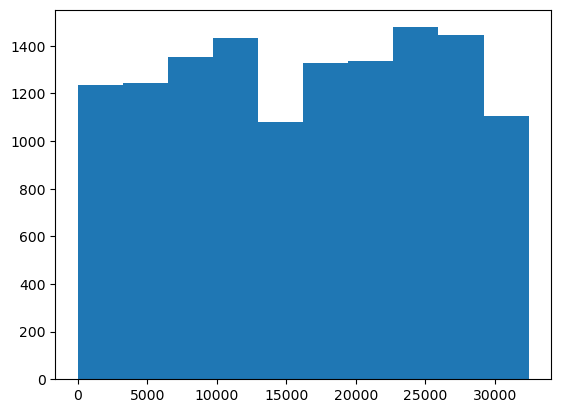

In [176]:

plt.hist(np.unique(list(img2dna_indices.keys())))